# The Magnitude limit of an Astronomical Image.

The `noise.fits` file is a fake, background-subtracted image of an empty patch of sky (it's actually just gaussian noise). The pixels have size $0.^"3$ on a side and its values are in units of $nJy$. What is the $1\sigma$ limiting magnitude on $2.^"5$-diameter apertures?

It will be useful to install the `Photutils` package: https://photutils.readthedocs.io/en/stable/install.html

## Let's take a look at the fake image first

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt

The following is general information about the structure of the file:

Filename: noise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (200, 200)   float64   
None


-----------------------------
Below is the header of the first HDU:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
EXTEND  =                    T                                                  


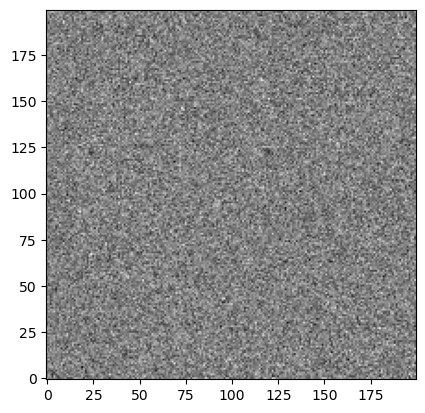

In [2]:
img = fits.open('noise.fits')

print("The following is general information about the structure of the file:\n")
print(img.info())

print("\n\n-----------------------------")
print("Below is the header of the first HDU:\n")
print(repr(img[0].header))

data = img[0].data

with plt.style.context("default"):
    plt.imshow(data, cmap='gray', origin='lower')

## Let's create a fake source to understand the concept of limiting magnitude

We will create a point source that has a gaussian profile (stars don't look like this in reality). The source has a FWHM~2".

In [3]:
import numpy as np
xx, yy = np.meshgrid(np.arange(-10, 11), np.arange(-10, 11))
g = np.exp(-(xx**2 + yy**2) / 2 / (0.85/0.3)**2)
g /= np.sum(g)  # This is just normalizing the total flux

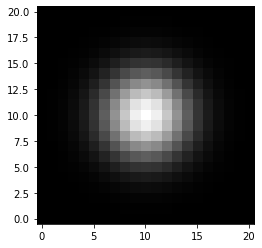

In [4]:
plt.imshow(g, cmap='gray');

Now we will normalize the flux within a 2.5" aperture.

In [5]:
from photutils import CircularAperture, aperture_photometry

(<matplotlib.patches.Circle at 0x137510ac0>,)

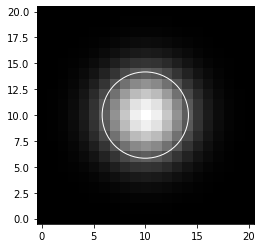

In [6]:
aperture_diameter_arcsecs = 2.5
pixel_scale = 0.3 # arcsecs/pixel
aperture_radius = 2.5 / pixel_scale / 2

central_aperture = CircularAperture((10,10), r=aperture_radius)

plt.imshow(g, cmap='gray')
central_aperture.plot(color='w')

The white circle is the 2.5" aperture. We will measure all the flux inside that aperture

In [7]:
flux_in_25 = aperture_photometry(g, central_aperture)
print(flux_in_25)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    10.0    10.0 0.6560418659060617


In [8]:
g = g / flux_in_25['aperture_sum']  # We normalize so that now the flux inside the aperture is 1.

## Adding the fake source to our fake noise image.

In [9]:
x = y = 50
patched = data.copy()
patched[x-10:x+11, y-10:y+11] += (g * 384.764 *   5)

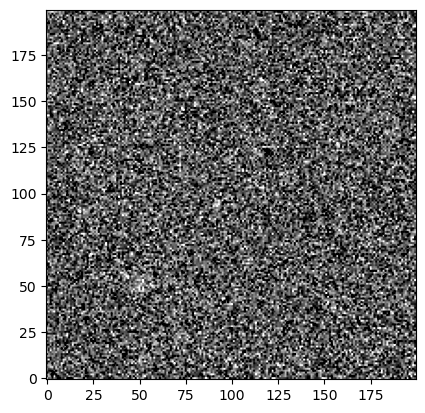

In [10]:
with plt.style.context("default"):
    plt.imshow(patched, cmap='gray', origin='lower', vmin=-50, vmax=100)

## How much fainter can the source be, so that we can still see it?

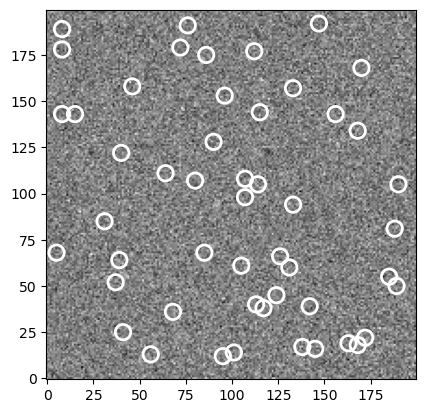

In [11]:
aperture_diameter_arcsecs = 2.5
pixel_scale = 0.3 # arcsecs/pixel
aperture_radius = 2.5 / pixel_scale / 2

min_center = int(np.ceil(aperture_radius))
max_center = int(np.floor(data.shape[0]-aperture_radius))

N_apertures = 50
x_centers = np.random.randint(min_center, max_center, size=N_apertures)
y_centers = np.random.randint(min_center, max_center, size=N_apertures)

random_apertures = CircularAperture(zip(x_centers, y_centers), r=aperture_radius)

with plt.style.context("default"):
    plt.imshow(data, cmap='gray', origin='lower')
    random_apertures.plot(color='w', lw=2)

In [12]:
photometry = aperture_photometry(data, random_apertures)
print(photometry)

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   142.0    39.0  -444.7975162040193
  2   145.0    16.0  -63.41547896997702
  3    72.0   179.0  -786.2408311131185
  4    86.0   175.0   616.8057651957246
  5   105.0    61.0  130.32033065358488
  6   189.0    50.0 -26.848121979477757
  7    90.0   128.0  -317.3703227022832
  8   156.0   143.0 -153.92155667905476
  9   114.0   105.0   442.1278673751205
 10   172.0    22.0    383.643739364448
...     ...     ...                 ...
 41   117.0    38.0  -418.1442514429825
 42   168.0   134.0   22.25500950400165
 43   113.0    40.0 -144.74747594613603
 44   138.0    17.0   193.1962202456678
 45    85.0    68.0   52.84188989292464
 46    40.0   122.0   168.8168843949327
 47   131.0    60.0 -100.90342958327395
 48    15.0   143.0  -233.9592161455488
 49    46.0   158.0 -134.53065039501809
 50   163.0    19.0  127.96964684176346
Length = 50 rows


The std of the fluxes: 278.633


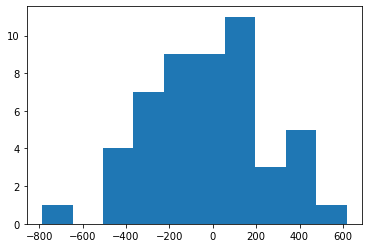

In [13]:
fluxes = photometry['aperture_sum'].data
plt.hist(fluxes)

fluxes_std = fluxes.std(ddof=1)
print('The std of the fluxes: {:.3f}'.format(fluxes_std))

In [14]:
mag_lim = 31.4 - 2.5 * np.log10(fluxes_std) # Here 31.4 is the AB zeropoint for nJy

print('The corresponding 1 sigma limiting magnitude is: {:.2f}'.format(mag_lim))

The corresponding 1 sigma limiting magnitude is: 25.29
